# Import + setup

In [11]:
data_dir = '../data/'
model_dir = '../models/'
results_dir = '../results/'

### Set enviornment variables

In [12]:
import subprocess
import os
import re

def load_shell_env(script_path):
    """
    Executes a shell script and captures the environment variables
    that it sets or modifies. Returns a dictionary of these changes.
    """
    # Execute the script and then 'env' to capture the environment before and after
    # Use 'setsid' to run in a new session to avoid process group issues with some scripts
    # Use 'bash -c' to ensure consistent shell behavior
    command = f'bash -c "source {script_path} >/dev/null 2>&1 && env"'

    # Capture the environment variables from the output
    try:
        # Use text=True for string output in Python 3.7+
        # Use encoding='utf-8' for older Python or specific needs
        result = subprocess.run(
            command,
            shell=True,
            capture_output=True,
            check=True,
            text=True,
            env=os.environ # Pass the current environment so 'source' can use it
        )

        new_env = {}
        for line in result.stdout.splitlines():
            if '=' in line:
                key, value = line.split('=', 1)
                new_env[key] = value

        # Compare with current environment to get only changes/additions
        # This is a simplification; a full diff is more complex but often not needed
        # For direct use in os.environ, just update with new_env
        return new_env

    except subprocess.CalledProcessError as e:
        print(f"Error executing shell script: {e}")
        print(f"Stdout:\n{e.stdout}")
        print(f"Stderr:\n{e.stderr}")
        return {}
    except FileNotFoundError:
        print(f"Error: Shell script not found at {script_path}")
        return {}

# Example Usage:
setup_script_path = '../hls4ml_setup.sh' # Or the full path if not in current directory

# Load the environment from setup.sh
print(f"Loading environment from {setup_script_path}...")
env_changes = load_shell_env(setup_script_path)

# Update the current Python process's environment
for key, value in env_changes.items():
    # Be careful with PATH. You might want to prepend/append strategically.
    # For simplicity, we just set it here.
    if key == 'PATH' and key in os.environ and value not in os.environ[key]:
         # Prepend new path entries from the script if they aren't already there
         # This is a basic approach and might need refinement for complex PATH modifications
         existing_paths = os.environ[key].split(os.pathsep)
         new_paths_from_script = value.split(os.pathsep)

         # Find new paths that are not already in the existing PATH
         paths_to_add = [p for p in new_paths_from_script if p not in existing_paths]

         if paths_to_add:
             os.environ[key] = os.pathsep.join(paths_to_add) + os.pathsep + os.environ[key]
             print(f"Appended new PATH entries: {paths_to_add}")
         else:
             os.environ[key] = value # Or just assign if no new distinct paths
             print(f"Updated PATH: {key}={value}")
    else:
        os.environ[key] = value
        # print(f"Set environment variable: {key}={value}") # Uncomment for verbose

print("Environment variables updated in Python kernel.")

Loading environment from ../hls4ml_setup.sh...
Updated PATH: PATH=/afs/slac.stanford.edu/g/reseng/vol30/synopsys/verdi/vR-2020.12-1/bin:/afs/slac.stanford.edu/g/reseng/vol33/synopsys/vcs/R-2020.12-1//bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Model_Composer/2024.1/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis_HLS/2024.1/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/microblaze/lin/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/microblaze/linux_toolchain/lin64_le/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/aarch32/lin/gcc-arm-linux-gnueabi/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/aarch32/lin/gcc-arm-none-eabi/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/aarch64/lin/aarch64-linux/bin:/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis/2024.1/gnu/a

### Import

In [13]:
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
# Import tf/keras modules
from keras.layers import Dense
from keras.layers import Input
# This clears the Keras session
tf.keras.backend.clear_session()

import os, sys

from sklearn.model_selection import train_test_split
import glob

from sklearn.metrics import roc_auc_score,roc_curve,auc

from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

import hls4ml

In [14]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

import hls4ml

# Utilities

### Plotting (hls4ml-tutorial)

In [15]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve

# confusion matrix code from Maurizio
# /eos/user/m/mpierini/DeepLearning/ML4FPGA/jupyter/HbbTagger_Conv1D.ipynb
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0, 1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plotRoc(fpr, tpr, auc, labels, linestyle, legend=True):
    for _i, label in enumerate(labels):
        plt.plot(
            tpr[label],
            fpr[label],
            label='{} tagger, AUC = {:.1f}%'.format(label.replace('j_', ''), auc[label] * 100.0),
            linestyle=linestyle,
        )
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001, 1)
    plt.grid(True)
    if legend:
        plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90, 'hls4ml', fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


def rocData(y, predict_test, labels):
    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:, i]
        df[label + '_pred'] = predict_test[:, i]

        fpr[label], tpr[label], threshold = roc_curve(df[label], df[label + '_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return fpr, tpr, auc1


def makeRoc(y, predict_test, labels, linestyle='-', legend=True):
    if 'j_index' in labels:
        labels.remove('j_index')

    fpr, tpr, auc1 = rocData(y, predict_test, labels)
    plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
    return predict_test


def print_dict(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent + 1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

### alt_CEPC functions

In [16]:
import os, sys

batchSize = 64

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)
    wf_i = data["wf_i"].astype(np.float32)        # (N, 3000)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)
    return wf_i, tag_values, tag_times

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, tlength])         # (N, 3000)
        tag_values.set_shape([None, 300])      # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            y = tf.numpy_function(
                func=lambda v, t: expand_values(v, t, tlength, ohe, combine),
                inp=[tag_values_ex, tag_times_ex],
                Tout=tf.float32
            )
            wf_i_ex.set_shape([tlength, 1])
            y.set_shape([tlength, 3])
            return wf_i_ex, y

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    #if shuffle:
    #    ds = ds.shuffle(len(file_list))

    ds = ds.flat_map(file_to_dataset)
    ds = ds.shuffle(512)  # shuffle individual examples
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}

def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((tlength,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    data[times] = values

    if ohe:
        ohe_data = np.zeros((tlength, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

import os, sys

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)
    wf_i = data["wf_i"].astype(np.float32)        # (N, 3000)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)
    return wf_i, tag_values, tag_times

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, tlength])         # (N, 3000)
        tag_values.set_shape([None, 300])      # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            y = tf.numpy_function(
                func=lambda v, t: expand_values(v, t, tlength, ohe, combine),
                inp=[tag_values_ex, tag_times_ex],
                Tout=tf.float32
            )
            wf_i_ex.set_shape([tlength, 1])
            y.set_shape([tlength, 3])
            return wf_i_ex, y

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    
    def plot_dndx_roc(ysel_test,pred_ytests,log=True):
        for j, alg in enumerate(pred_ytests):
            print(alg)
            fpr, tpr, thresholds = roc_curve(((ysel_test[alg][:,:] if isinstance(ysel_test, dict) else ysel_test[:,:])==0).flatten(),
                                            (pred_ytests[alg][:,:,0]).flatten())
            auc = roc_auc_score(((ysel_test[alg][:,:] if isinstance(ysel_test, dict) else ysel_test[:,:])==0).flatten(), 
                                (pred_ytests[alg][:,:,0]).flatten())
            plt.plot(tpr,fpr, label='%s (AUC=%.3f)'%(alg,auc),linestyle=['solid','dashed','dotted','dashdot'][j])
        
        if log:
            plt.yscale('log')

        plt.xlabel('TPR')
        plt.ylabel('FPR')
        plt.legend(bbox_to_anchor=(1.05, 1))
        

def plot_dndx_roc(ysel_test, pred_ytests, log=True, batch_size=1000000, fpr_points=100000):
    """
    Computes and averages ROC curves in batches for each algorithm.

    Parameters:
    - ysel_test: array or dict of arrays of shape [N, ...]
    - pred_ytests: dict of arrays of shape [N, ..., 1]
    - batch_size: int, number of samples per batch
    - fpr_points: int, number of fixed FPR points for interpolation
    """
    fixed_fpr = np.linspace(0, 1, fpr_points)

    for j, alg in enumerate(pred_ytests):
        y_true_all = ((ysel_test[alg] if isinstance(ysel_test, dict) else ysel_test) == 0).flatten()
        y_score_all = pred_ytests[alg][:, :, 0].flatten()

        n_samples = len(y_true_all)
        tpr_batches = []

        for i in tqdm(range(0, n_samples, batch_size)):
            y_true_batch = y_true_all[i:i+batch_size]
            y_score_batch = y_score_all[i:i+batch_size]

            # Skip batch if only one class is present (ROC can't be computed)
            if np.unique(y_true_batch).size < 2:
                continue

            fpr, tpr, _ = roc_curve(y_true_batch, y_score_batch)
            interp_tpr = np.interp(fixed_fpr, fpr, tpr, left=0, right=1)
            tpr_batches.append(interp_tpr)

        if not tpr_batches:
            print(f"No valid batches found for algorithm: {alg}")
            continue

        mean_tpr = np.mean(tpr_batches, axis=0)
        final_auc = auc(fixed_fpr, mean_tpr)

        linestyle = ['solid', 'dashed', 'dotted', 'dashdot'][j % 4]
        plt.plot(mean_tpr, fixed_fpr, label=f'{alg} (AUC={final_auc:.3f})', linestyle=linestyle)

    if log:
        plt.yscale('log')

    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(bbox_to_anchor=(1.05, 1))


### My functions

In [18]:
from scipy.stats import pearsonr

def get_efficiency(ground_truth, predictions, ntest):
    return np.sum(predictions[ground_truth[:ntest]>0]>0)/np.sum(predictions[ground_truth[:ntest]>0]>-1)

def get_purity(ground_truth, predictions, ntest):
    return np.sum(predictions[ground_truth[:ntest]>0]>0)/np.sum(predictions[ground_truth[:ntest]>-1]>0)

def make_corr_plot(actual, predicted):

    m = 1
    b = 0
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red')
    plt.xlabel('Truth Number of Primary Ionizations')
    plt.ylabel('Predicted Number of Primary Ionizations')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Truth vs. Predicted Number of Primary Ionizations')

def plot_percent_error(actual, predicted):
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]
    error = ((predicted - actual)/actual) * 100

    plt.hist(error,bins=np.arange(-100, 100, 2),histtype='bar',label='Error', edgecolor="black", fc="#69b3a2", alpha=0.3)
    plt.title('Histogram of Percent Error')
    plt.xlabel('Error (%)')

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    plt.axvline(mean, color='red', linestyle='--', linewidth=2)
    
    plt.text(0.05, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
    transform=plt.gca().transAxes,
    horizontalalignment='left',    
    verticalalignment='top',  
    color='black', fontsize=11)
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)

# Load data

In [9]:
num_timepoints = 500
truncate = True

compress = False
compress_factor = 1

if truncate == True:
    num_timepoints = 500

In [10]:
data = load_data(data_dir + "processed_data_train/",
                 ["batch_0.npz",
                  #"batch_1.npz",
                  #"batch_2.npz",
                  #"batch_3.npz",
                  #"batch_4.npz", 
                 ])
data = {d:data[d][:1000] for d in data} # reduce size in memory

if truncate:
    data['wf_i'] = data['wf_i'][:,:num_timepoints]
    mask = data['tag_times'] >= num_timepoints
    data['tag_times'][mask] = 0
    data['tag_values'][mask] = 0

testdata = load_data(data_dir + "processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

if compress:
    compressed = []
    for i in range(testdata['wf_i'].shape[0]):
        wf_i = testdata['wf_i'][i]
        wf_i = wf_i.reshape(-1, compress_factor)
        wf_i = wf_i.mean(axis=1)

        compressed.append(wf_i)

    testdata['wf_i'] = np.asarray(compressed)

testdata = {d:testdata[d][:100000] for d in testdata} # reduce size in memory

if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0

(0.0, 2.3171490713953973)

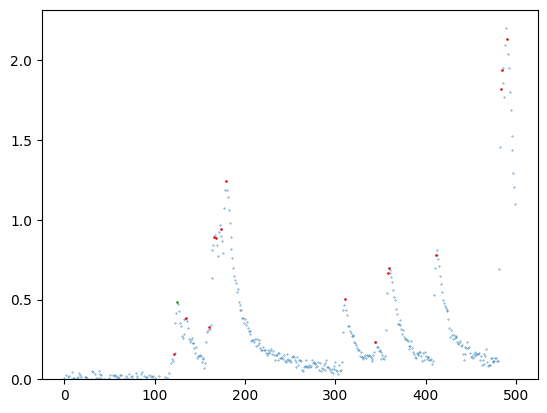

In [11]:
iev = 0
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=0.1);
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=0.6,color='r')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=0.4,color='g')
plt.ylim(0)

In [12]:
ground_truth = batched_expand_values(testdata['tag_values'],testdata['tag_times'],ohe=False)

100%|██████████| 100/100 [00:00<00:00, 350.12it/s]


In [13]:
# percentage of ionizations compared to background 

count = 0
for i in range(ground_truth.shape[0]):
    count += ((ground_truth[0] == 1).sum() + (ground_truth[0] == 2).sum())

print(count)
print(count/(1000*3000))

1100000
0.36666666666666664


# Load model

In [ ]:
import keras
model = keras.models.load_model(model_dir + 'DNN_8_32_8.keras')

In [21]:
# if yes quantization

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model(model_dir + 'TEST_8_5_bit_quantization_DNN_8_32_8.h5', custom_objects=co)

In [ ]:
ntest = 10000

# preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

In [ ]:
preds = model.predict(testdata['wf_i'][:10000])

313/313 [==============================] - 0s 313us/step


In [ ]:
np.sum(testdata['tag_values'] == 1, axis = 1).shape

(100000,)

In [40]:
preds = preds.flatten()

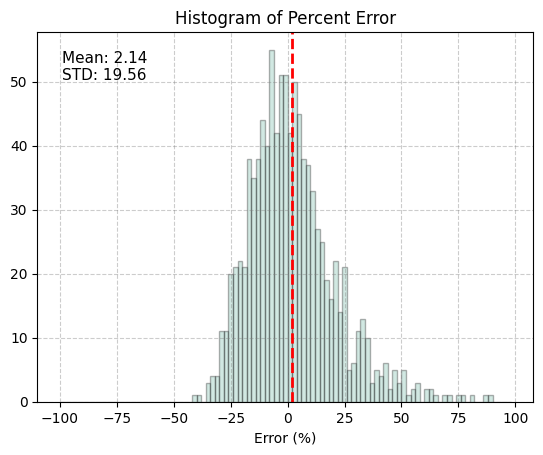

In [41]:
plot_percent_error(actual[:1000], preds[:1000])

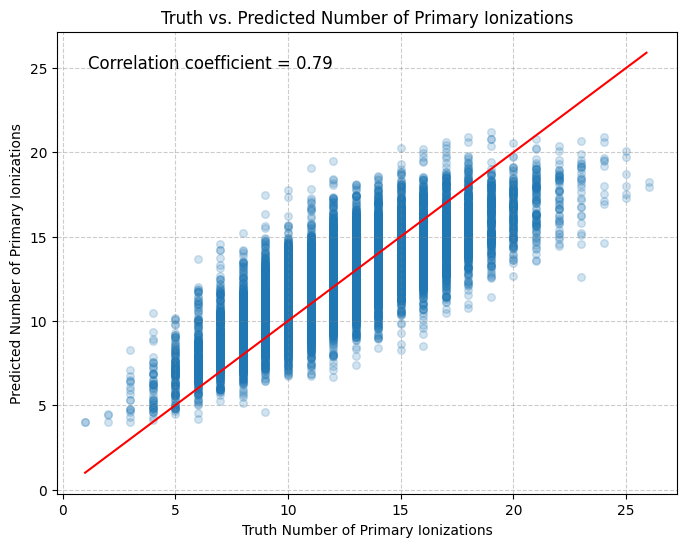

In [42]:
make_corr_plot(actual, preds)

# HLS4ML

### Baseline

In [ ]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
print("-----------------------------------")
print("Configuration")
print_dict(config)
print("-----------------------------------")
# for layer in config['LayerName'].keys():
#     config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, io_type = 'io_parallel', backend='Vitis', output_dir='test/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_activation_10, layer type: Activation, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_dense_8, layer type: QDense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: q_activation_11, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_9, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: q_activation_12, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_dense_10, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: q_activation_13, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_11, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 1]
Layer name: q_activation_14, layer type: Activation, input shapes: 

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [23]:
hls_model.compile()

Writing HLS project
Done


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
X_test = np.ascontiguousarray(testdata['wf_i'])
raw_y_hls = hls_model.predict(X_test)

In [ ]:
raw_y_hls

array([[ 7.86497 ],
       [ 8.734197],
       [13.085061],
       ...,
       [11.351624],
       [14.974631],
       [11.351323]], dtype=float32)

In [24]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Thu Aug 28 09:48:23 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'dyilmaz' on host 'rdsrv409' (Linux_x86_64 version 6.8.0-60-generic) on Thu Aug 28 09:48:24 PDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/u1/dyilmaz/ML_FPGA_DC/drift-chamber-ml/drift-chamber-ml-final/code/test/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/u1/dyilmaz/ML_FPGA_DC/drift-chamber

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.593',
  'BestLatency': '9',
  'WorstLatency': '9',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'DSP': '92',
  'FF': '20320',
  'LUT': '140586',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [ ]:
hls4ml.report.read_vivado_report('test/hls4ml_prj')

Found 1 solution(s) in test/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Aug 26 08:20:37 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.629 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------+----

# Kaon Pion

### Utilities

In [21]:
from qkeras import *
input_quantizer = quantized_bits(bits=16, integer=4, symmetric=1)

def quantize_input(data):
    return input_quantizer(data).numpy()

truncate = True
num_timepoints = 500

def process_momentum_subsets_MODEL(momentum_subsets, model, max_events, quantize):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        if quantize:
            primaries = np.asarray(model.predict(quantize_input(subset['wf_i'][:max_events]))).flatten()
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)



kaon_data = load_data(data_dir + "kaon/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

pion_data = load_data(data_dir + "pion/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

if truncate:
    kaon_data['wf_i'] = kaon_data['wf_i'][:,:num_timepoints]
    mask = kaon_data['tag_times'] >= num_timepoints
    kaon_data['tag_times'][mask] = 0
    kaon_data['tag_values'][mask] = 0

if truncate:
    pion_data['wf_i'] = pion_data['wf_i'][:,:num_timepoints]
    mask = pion_data['tag_times'] >= num_timepoints
    pion_data['tag_times'][mask] = 0
    pion_data['tag_values'][mask] = 0

def create_momentum_subsets(data, particle_name):

    unique_momenta = np.unique(data['mom'])
    momentum_subsets = {}
    
    print(f"\n{particle_name} data - Available momenta: {unique_momenta}")
    
    for mom_value in unique_momenta:
        mom_mask = data['mom'] == mom_value
        
        subset = {}
        for key in data.keys():
            subset[key] = data[key][mom_mask]
        
        momentum_subsets[mom_value] = subset
        
        print(f"  Momentum {mom_value}: {np.sum(mom_mask)} events")
    
    return momentum_subsets

pion_momentum_subsets = create_momentum_subsets(pion_data, "Pion")

kaon_momentum_subsets = create_momentum_subsets(kaon_data, "Kaon")


# pion_5GeV = pion_momentum_subsets[5.0]
# pion_10GeV = pion_momentum_subsets[10.0]

# kaon_5GeV = kaon_momentum_subsets[5.0]
# kaon_10GeV = kaon_momentum_subsets[10.0]


Pion data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 80000 events
  Momentum 7.5: 60000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 90000 events
  Momentum 15.0: 70000 events
  Momentum 17.5: 50000 events
  Momentum 20.0: 70000 events

Kaon data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 70000 events
  Momentum 7.5: 50000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 60000 events
  Momentum 15.0: 80000 events
  Momentum 17.5: 80000 events
  Momentum 20.0: 80000 events


### Calculation

In [22]:
from pathlib import Path
dir = model_dir + 'hls4ml/'
model_paths = [str(p.resolve()) for p in Path(dir).rglob('*') if p.is_file()]

kp_separations = []

for model_path in model_paths:
    # checking if model is quantized or not
    name = model_path.split('/')[-1]
    h5_or_keras = name.split('.')[-1]
    print(name)

    if (h5_or_keras == 'h5'):
        from qkeras.utils import _add_supported_quantized_objects
        co = {}
        _add_supported_quantized_objects(co)
        model = keras.models.load_model(model_path, custom_objects=co)

    else:
        model = keras.models.load_model(model_path)

    config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
    print("-----------------------------------")
    print("Configuration")
    # print_dict(config)
    print("-----------------------------------")
    # for layer in config['LayerName'].keys():
    #     config['LayerName'][layer]['Trace'] = True
    hls_model = hls4ml.converters.convert_from_keras_model(
        model, hls_config=config, io_type = 'io_parallel', backend='Vitis', output_dir='test/hls4ml_prj', part='xcu250-figd2104-2L-e'
    )

    hls_model.compile()


    mean_pion_model, std_pion_model = process_momentum_subsets_MODEL(pion_momentum_subsets, hls_model, 50000, quantize= True)
    mean_kaon_model, std_kaon_model = process_momentum_subsets_MODEL(kaon_momentum_subsets, hls_model, 50000, quantize=True)

    print(f"mean_pion_model = {mean_pion_model}")
    print(f"mean_kaon_model = {mean_kaon_model}")
    print(f"std_pion_model = {std_pion_model}")
    print(f"std_kaon_model = {std_kaon_model}")

    kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
    kp_separation_MODEL_scaled = kp_separation_MODEL

    print(kp_separation_MODEL)
    kp_separations.append(kp_separation_MODEL_scaled)

DNN_8_32_8.keras
Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 32]], output shape: [Non

Interpreting Model
Topology:
Layer name: input_13, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_activation_60, layer type: Activation, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_dense_48, layer type: QDense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: q_activation_61, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_49, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: q_activation_62, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_dense_50, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: q_activation_63, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_51, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 1]
Layer name: q_activation_64, layer type: Activation, input shape

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Done
mean_pion_model = [12.346405 12.715913 13.062882 13.178156 13.228654 13.294591 13.336811]
mean_kaon_model = [11.399652 11.811978 12.13692  12.31504  12.463637 12.579031 12.678208]
std_pion_model = [2.755281  2.7584703 2.7689126 2.770166  2.7644668 2.7612262 2.7342384]
std_kaon_model = [2.744337  2.758578  2.7674665 2.7872274 2.7818577 2.7680628 2.767574 ]
[0.34429792 0.3276877  0.33450112 0.31061912 0.27586433 0.2588253
 0.239413  ]
10_5_500_dense_8_32_8_lr=3e-4.h5
Interpreting Model
Topology:
Layer name: input_13, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_activation_60, layer type: Activation, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_dense_48, layer type: QDense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: q_activation_61, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_49, layer type: QDense, input shapes: [[None, 8]], output shape: [

In [ ]:
kp_separation_MODEL

array([0.34691727, 0.3330357 , 0.34003016, 0.31206596, 0.27897048,
       0.26003128, 0.24141768], dtype=float32)

In [ ]:
model = keras.models.load_model('models/FINAL_SPECS/500_dense_8_32_8_lr=6e-4.keras')

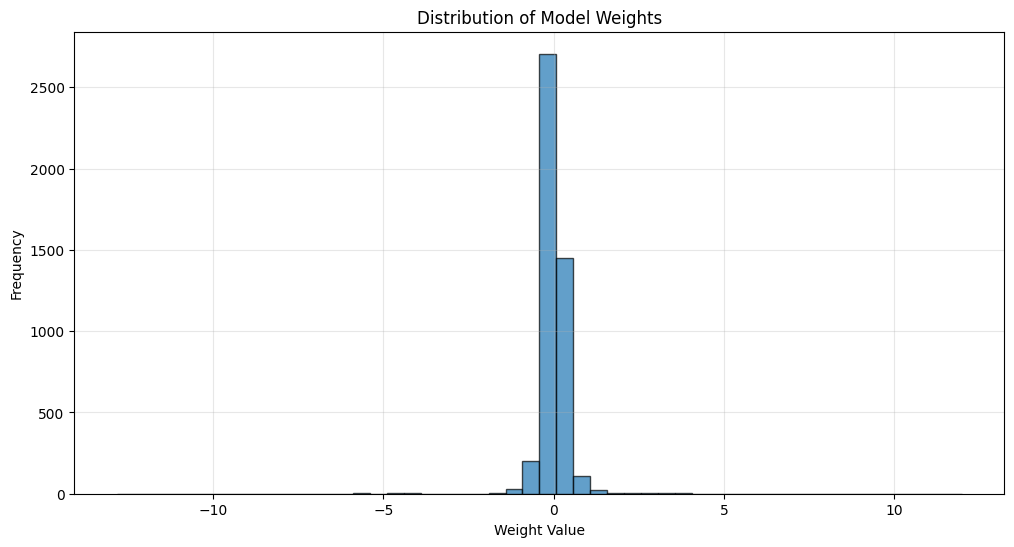

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Get all trainable weights from your model
weights = []
for layer in model.layers:
    if layer.trainable_weights:
        for weight in layer.trainable_weights:
            weights.extend(weight.numpy().flatten())

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(weights, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Model Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Script

In [10]:
from pathlib import Path
import json
dir = model_dir + 'hls4ml/'
model_paths = [str(p.resolve()) for p in Path(dir).rglob('*') if p.is_file()]
ntest = 10000

model_dict = {'Name': [],
              'Latency (cycles)': [],
              'DSPs': [],
              'LUTs': [],
              'FFs': [],
              'I/O Type': [], 
            #   'Mean Percent Error': [],
            #   'STD Percent Error': [],
              'Input Shape': []
            }

for model_path in model_paths:
    # checking if model is quantized or not
    name = model_path.split('/')[-1]
    h5_or_keras = name.split('.')[-1]
    print(name)

    if (h5_or_keras == 'h5'):
        from qkeras.utils import _add_supported_quantized_objects
        co = {}
        _add_supported_quantized_objects(co)
        model = keras.models.load_model(model_path, custom_objects=co)

    else:
        model = keras.models.load_model(model_path)

    input_shape = model.input_shape[1]

    # preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
    # actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

    # error = ((preds - actual)/actual) * 100

    # mean = np.mean(error)
    # std = np.std(error.astype(np.float32))

    config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
    output_dir = model_path.split('/')[-1] + '/hls4ml_prj'
    hls_model = hls4ml.converters.convert_from_keras_model(
        model, hls_config=config, io_type = 'io_parallel', backend='Vitis', output_dir=output_dir, part='xcu250-figd2104-2L-e'
    )

    hls_model.compile()

    hls_model.build(csim=False)

    file_path = output_dir + '/myproject_prj/solution1/solution1_data.json'

    with open(file_path, 'r') as f:
        data = json.load(f)
    
    latency = data['ModuleInfo']['Metrics']['myproject']['Latency']['LatencyWorst']
    dsp = data['ModuleInfo']['Metrics']['myproject']['Area']['DSP']
    lut = data['ModuleInfo']['Metrics']['myproject']['Area']['LUT']
    ff = data['ModuleInfo']['Metrics']['myproject']['Area']['FF']

    model_dict['Name'].append(name)
    model_dict['Latency (cycles)'].append(latency)
    model_dict['DSPs'].append(dsp)
    model_dict['LUTs'].append(lut)
    model_dict['I/O Type'].append('parallel')
    # model_dict['Mean Percent Error'].append(mean)
    # model_dict['STD Percent Error'].append(std)
    model_dict['Input Shape'] = input_shape
    model_dict['FFs'].append(ff)


df = pd.DataFrame(model_dict)
print(df)
# df.to_csv('model_summary.csv')

DNN_8_32_8.keras
Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 8]], output shape:

Interpreting Model
Topology:
Layer name: input_13, layer type: InputLayer, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_activation_60, layer type: Activation, input shapes: [[None, 500]], output shape: [None, 500]
Layer name: q_dense_48, layer type: QDense, input shapes: [[None, 500]], output shape: [None, 8]
Layer name: q_activation_61, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_49, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 32]
Layer name: q_activation_62, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_dense_50, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 8]
Layer name: q_activation_63, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: q_dense_51, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 1]
Layer name: q_activation_64, layer type: Activation, input shape

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(



****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Thu Aug 28 11:45:56 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /afs/slac.stanford.edu/g/reseng/vol39/xilinx/2024.1/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'dyilmaz' on host 'rdsrv409' (Linux_x86_64 version 6.8.0-60-generic) on Thu Aug 28 11:45:57 PDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/u1/dyilmaz/ML_FPGA_DC/drift-chamber-ml/drift-chamber-ml-final/code/10_5_0.6_pruned_500_dense_8_32_8_lr=3e-4.h5/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening projec

In [11]:
df.to_csv(results_dir + 'model_summary.csv')

In [12]:
import pandas as pd
df = pd.read_csv(results_dir + 'model_summary.csv')


In [13]:
df

,Unnamed: 0,Name,Latency (cycles),DSPs,LUTs,FFs,I/O Type,Input Shape
0,0,DNN_8_32_8.keras,11,3399,183726,44946,parallel,500
1,1,10_5_0.6_pruned_500_dense_8_32_8_lr=3e-4.h5,9,39,83417,22029,parallel,500
2,2,10_5_500_dense_8_32_8_lr=3e-4.h5,11,19,127818,26002,parallel,500
